In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

In [2]:
# imports
from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.utils import to_categorical

In [3]:
# imports
import numpy as np
import random

# prepare data

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [6]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

In [7]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
# data augmentation

train_datagen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=64)

# **Part 1: الف**

In [10]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)
hidden1 = Dense(128, activation='elu')(flat)
output = Dense(10, activation='softmax')(hidden1)

model_no1 = Model(input, output)

In [11]:
# compile
model_no1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_no1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0     

In [12]:
# training

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=0, patience=20)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_acc",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no1 = model_no1.fit(train_generator,
            epochs=100,
            validation_data=validation_generator,
            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
4/4 [==============================] - 4s 405ms/step - loss: 2.4700 - acc: 0.1455 - val_loss: 2.2906 - val_acc: 0.1008

Epoch 00001: val_acc improved from -inf to 0.10080, saving model to model_checkpoint.h5
Epoch 2/100
4/4 [==============================] - 1s 241ms/step - loss: 2.2657 - acc: 0.1623 - val_loss: 2.2301 - val_acc: 0.1672

Epoch 00002: val_acc improved from 0.10080 to 0.16720, saving model to model_checkpoint.h5
Epoch 3/100
4/4 [==============================] - 1s 238ms/step - loss: 2.2480 - acc: 0.1773 - val_loss: 2.1649 - val_acc: 0.1922

Epoch 00003: val_acc improved from 0.16720 to 0.19220, saving model to model_checkpoint.h5
Epoch 4/100
4/4 [==============================] - 1s 241ms/step - loss: 2.1220 - acc: 0.1861 - val_loss: 2.1059 - val_acc: 0.2274

Epoch 00004: val_acc improved from 0.19220 to 0.22740, saving model to model_checkpoint.h5
Epoch 5/100
4/4 [==============================] - 1s 257ms/step - loss: 2.1294 - acc: 0.2046 - val_loss: 2.065

# **Part 2: ب**

In [9]:
def rotate_image(im,iterations=None):
  if not iterations:
    iterations = random.randint(0,3)
  y = [0,0,0,0]
  y[iterations]=1
  for i in range(iterations):
    im = np.rot90(im)
  return im,y

In [ ]:
def make_rotated_data(x_train, x_test):
    xy_rot0_train = list(zip(*[rotate_image(im, 0) for im in x_train]))
    xy_rot0_test = list(zip(*[rotate_image(im, 0) for im in x_test]))

    x_rot0_train=np.array(xy_rot0_train[0][:])
    y_rot0_train=np.array(xy_rot0_train[1][:])
    x_rot0_test=np.array(xy_rot0_test[0][:])
    y_rot0_test=np.array(xy_rot0_test[1][:])




    xy_rot90_train = list(zip(*[rotate_image(im, 1) for im in x_train]))
    xy_rot90_test = list(zip(*[rotate_image(im, 1) for im in x_test]))

    x_rot90_train=np.array(xy_rot90_train[0][:])
    y_rot90_train=np.array(xy_rot90_train[1][:])
    x_rot90_test=np.array(xy_rot90_test[0][:])
    y_rot90_test=np.array(xy_rot90_test[1][:])





    xy_rot180_train = list(zip(*[rotate_image(im, 2) for im in x_train]))
    xy_rot180_test = list(zip(*[rotate_image(im, 2) for im in x_test]))

    x_rot180_train=np.array(xy_rot180_train[0][:])
    y_rot180_train=np.array(xy_rot180_train[1][:])
    x_rot180_test=np.array(xy_rot180_test[0][:])
    y_rot180_test=np.array(xy_rot180_test[1][:])





    xy_rot270_train = list(zip(*[rotate_image(im, 3) for im in x_train]))
    xy_rot270_test = list(zip(*[rotate_image(im, 3) for im in x_test]))
    
    x_rot270_train=np.array(xy_rot270_train[0][:])
    y_rot270_train=np.array(xy_rot270_train[1][:])
    x_rot270_test=np.array(xy_rot270_test[0][:])
    y_rot270_test=np.array(xy_rot270_test[1][:])


    x_rot_train = np.concatenate([x_rot0_train, x_rot90_train, x_rot180_train, x_rot270_train] , axis=0)
    y_rot_train = np.concatenate([y_rot0_train, y_rot90_train, y_rot180_train, y_rot270_train] , axis=0)
    x_rot_test = np.concatenate([x_rot0_test, x_rot90_test, x_rot180_test, x_rot270_test] , axis=0)
    y_rot_test = np.concatenate([y_rot0_test, y_rot90_test, y_rot180_test, y_rot270_test] , axis=0)

    return x_rot_train,y_rot_train,x_rot_test,y_rot_test

In [ ]:
x_rot_train,y_rot_train,x_rot_test,y_rot_test = make_rotated_data(x_unlabeld,x_test)

In [ ]:
print(x_rot_train.shape)
print(y_rot_train.shape)
print(x_rot_test.shape)
print(y_rot_test.shape)

(199200, 32, 32, 3)
(199200, 4)
(40000, 32, 32, 3)
(40000, 4)


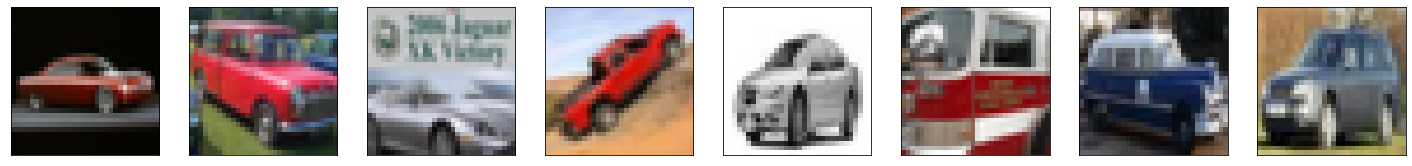

In [ ]:
plt.figure(figsize=(25, 4))
for i in range(8):
  plt.subplot(1, 8, i + 1)
  plt.imshow(x_unlabeld[i])
  plt.xticks([])
  plt.yticks([])


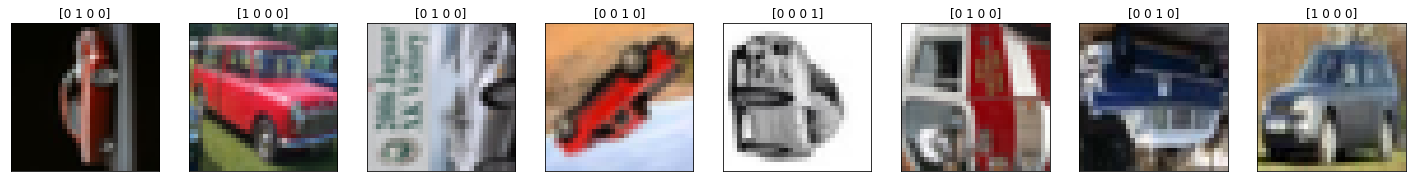

In [ ]:
plt.figure(figsize=(25, 4))
for i in range(8):
  plt.subplot(1, 8, i + 1)
  plt.imshow(x_rot_train[i])
  plt.xticks([])
  plt.yticks([])
  plt.title(str(y_rot_train[i]))

In [ ]:
# data augmentation
rot_train_datagen = ImageDataGenerator(    
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5,1.5],
    fill_mode='nearest')

rot_test_datagen = ImageDataGenerator(rescale=1./255)

rot_train_generator = rot_train_datagen.flow(x_rot_train, y_rot_train, batch_size=256)
rot_validation_generator = rot_test_datagen.flow(x_rot_test, y_rot_test, batch_size=256)

In [ ]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)
hidden1 = Dense(128, activation='elu')(flat)
output = Dense(4, activation='softmax')(hidden1)

model_no2 = Model(input, output)

In [ ]:
# compile

model_no2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_no2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0   

In [ ]:
# training

rot_path_checkpoint = "rotation_model_checkpoint.h5"
rot_es_callback = keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=0.001, patience=2)

rot_modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_acc",
    filepath=rot_path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no2 = model_no2.fit(rot_train_generator,
            epochs=100,
            validation_data=rot_validation_generator,
            callbacks=[rot_es_callback, rot_modelckpt_callback])

Epoch 1/100
779/779 [==============================] - 167s 213ms/step - loss: 1.0945 - acc: 0.5215 - val_loss: 0.8378 - val_acc: 0.6510

Epoch 00001: val_acc improved from -inf to 0.65102, saving model to rotation_model_checkpoint.h5
Epoch 2/100
779/779 [==============================] - 166s 213ms/step - loss: 0.8847 - acc: 0.6332 - val_loss: 0.7365 - val_acc: 0.7029

Epoch 00002: val_acc improved from 0.65102 to 0.70290, saving model to rotation_model_checkpoint.h5
Epoch 3/100
779/779 [==============================] - 165s 211ms/step - loss: 0.8059 - acc: 0.6680 - val_loss: 0.6985 - val_acc: 0.7186

Epoch 00003: val_acc improved from 0.70290 to 0.71855, saving model to rotation_model_checkpoint.h5
Epoch 4/100
779/779 [==============================] - 164s 211ms/step - loss: 0.7595 - acc: 0.6921 - val_loss: 0.6586 - val_acc: 0.7386

Epoch 00004: val_acc improved from 0.71855 to 0.73857, saving model to rotation_model_checkpoint.h5
Epoch 5/100
779/779 [==============================

In [ ]:
model_no2.save(rot_path_checkpoint)

In [ ]:
# define model

rot_model= keras.models.load_model(rot_path_checkpoint)
rot_model.trainable = True

x = rot_model.layers[-2].output
x = Dense(10, activation='softmax')(x)
model_no3 = Model(rot_model.inputs,x)

In [ ]:
# compile
model_no3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_no3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0   

In [ ]:
# training


main_path_checkpoint = "main_model_checkpoint.h5"
main_es_callback = keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=0, patience=20)

main_modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_acc",
    filepath=main_path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


history_no3 = model_no3.fit(train_generator,
            epochs=500,
            validation_data=validation_generator,
            callbacks=[main_es_callback, main_modelckpt_callback])

Epoch 1/500
4/4 [==============================] - 2s 422ms/step - loss: 4.2774 - acc: 0.1421 - val_loss: 3.1854 - val_acc: 0.1322

Epoch 00001: val_acc improved from -inf to 0.13220, saving model to main_model_checkpoint.h5
Epoch 2/500
4/4 [==============================] - 1s 361ms/step - loss: 2.9863 - acc: 0.1387 - val_loss: 2.6029 - val_acc: 0.1171

Epoch 00002: val_acc did not improve from 0.13220
Epoch 3/500
4/4 [==============================] - 1s 357ms/step - loss: 2.6915 - acc: 0.1101 - val_loss: 2.4323 - val_acc: 0.1082

Epoch 00003: val_acc did not improve from 0.13220
Epoch 4/500
4/4 [==============================] - 1s 363ms/step - loss: 2.4796 - acc: 0.0891 - val_loss: 2.3320 - val_acc: 0.1101

Epoch 00004: val_acc did not improve from 0.13220
Epoch 5/500
4/4 [==============================] - 1s 386ms/step - loss: 2.3303 - acc: 0.1730 - val_loss: 2.2508 - val_acc: 0.1215

Epoch 00005: val_acc did not improve from 0.13220
Epoch 6/500
4/4 [==============================

# **Part 3: پ**

In [10]:
def rotate_labeling(x):
    xy_rot = list(zip(*[rotate_image(im) for im in x]))

    x_rot = np.array(xy_rot[0][:])
    y_rot = np.array(xy_rot[1][:])


    return x_rot,y_rot

In [11]:
def generate_class(im):
  y = [0]
  for i in range(9):
    y.append(0)
  return im ,y

def class_labeling(x):
  xy_class = list(zip(*[generate_class(im) for im in x]))

  y_class = np.array(xy_class[1][:])

  return y_class


In [12]:
# data preparation

# angel label
x_rot_train1, y_rot_train1 = rotate_labeling(x_unlabeld)
x_rot_train2, y_rot_train2 = rotate_labeling(x_train)
x_rot_test, y_rot_test = rotate_labeling(x_test)

# class label
y_class_train1 = class_labeling(x_rot_train1)


# concatenation
X_train = np.concatenate([x_rot_train1, x_rot_train2] , axis=0)
Y_train = {'class_output': np.concatenate([y_class_train1, y_train] , axis=0),
           'rotation_output': np.concatenate([y_rot_train1, y_rot_train2] , axis=0)}

X_test =  x_rot_test
Y_test =  {'class_output': y_test, 'rotation_output': y_rot_test}

In [13]:
print(X_train.shape)
print(np.concatenate([y_class_train1, y_train] , axis=0).shape)
print(np.concatenate([y_rot_train1, y_rot_train2] , axis=0).shape)
print(X_test.shape)
print(y_test.shape)
print(y_rot_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(50000, 4)
(10000, 32, 32, 3)
(10000, 10)
(10000, 4)


## {'class_output':1000000,'rotation_output':1000}

In [14]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [15]:
model_no4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

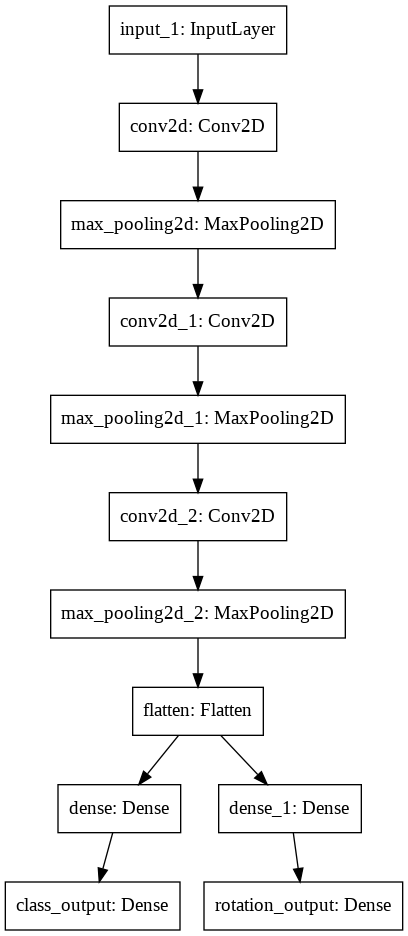

In [16]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [17]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':1000000,
                'rotation_output':1000}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [18]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 41s 6ms/step - loss: 441690.8535 - class_output_loss: 0.3964 - rotation_output_loss: 45.3339 - class_output_accuracy: 0.1244 - rotation_output_accuracy: 0.3044 - val_loss: 1329277824.0000 - val_class_output_loss: 1328.8199 - val_rotation_output_loss: 457.9732 - val_class_output_accuracy: 0.0917 - val_rotation_output_accuracy: 0.3302

Epoch 00001: val_class_output_accuracy improved from -inf to 0.09170, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 9177936.6346 - class_output_loss: 8.4045 - rotation_output_loss: 773.4105 - class_output_accuracy: 0.1373 - rotation_output_accuracy: 0.3426 - val_loss: 6213282816.0000 - val_class_output_loss: 6210.8970 - val_rotation_output_loss: 2385.4314 - val_class_output_accuracy: 0.0887 - val_rotation_output_accuracy: 0.3134

Epoch 00002: val_class_output_accuracy did not improve from 0.09170
Epoch 3/100
1563/1563 [==

## {'class_output':1000,'rotation_output':1000000}

In [19]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [20]:
model_no4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   18496       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

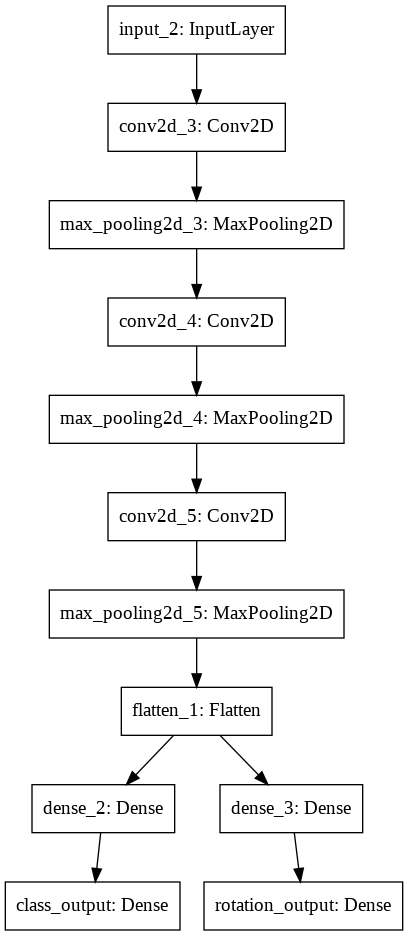

In [21]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [22]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':1000,
                'rotation_output':1000000}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [23]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 3344444.4752 - class_output_loss: 0.0308 - rotation_output_loss: 3.3444 - class_output_accuracy: 0.0395 - rotation_output_accuracy: 0.3372 - val_loss: 1773646.0000 - val_class_output_loss: 5.1096 - val_rotation_output_loss: 1.7685 - val_class_output_accuracy: 0.0936 - val_rotation_output_accuracy: 0.4493

Epoch 00001: val_class_output_accuracy improved from -inf to 0.09360, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1718633.6708 - class_output_loss: 0.0163 - rotation_output_loss: 1.7186 - class_output_accuracy: 0.0277 - rotation_output_accuracy: 0.4559 - val_loss: 2024391.1250 - val_class_output_loss: 6.4565 - val_rotation_output_loss: 2.0179 - val_class_output_accuracy: 0.1004 - val_rotation_output_accuracy: 0.4539

Epoch 00002: val_class_output_accuracy improved from 0.09360 to 0.10040, saving model to multi_output_model_check

## {'class_output':1,'rotation_output':1}

In [24]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [25]:
model_no4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

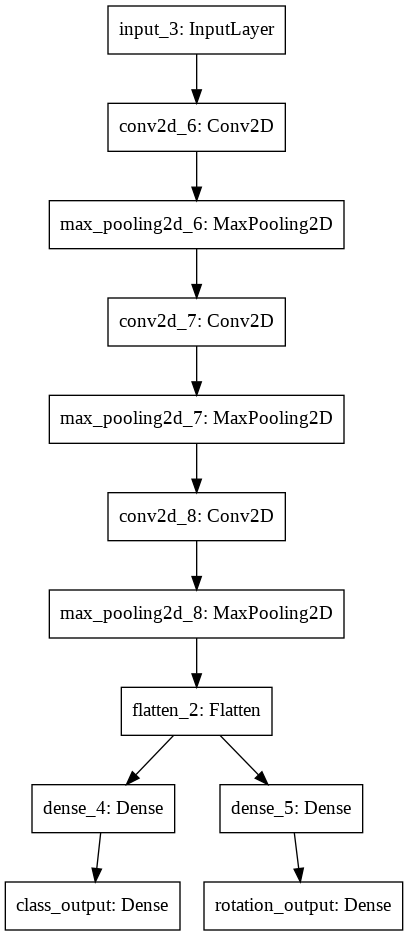

In [26]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [27]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':1,
                'rotation_output':1}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [28]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 37.8540 - class_output_loss: 0.3895 - rotation_output_loss: 37.4645 - class_output_accuracy: 0.0880 - rotation_output_accuracy: 0.3121 - val_loss: 1584.3617 - val_class_output_loss: 1199.8933 - val_rotation_output_loss: 384.4690 - val_class_output_accuracy: 0.0813 - val_rotation_output_accuracy: 0.3504

Epoch 00001: val_class_output_accuracy improved from -inf to 0.08130, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 655.1333 - class_output_loss: 8.6918 - rotation_output_loss: 646.4415 - class_output_accuracy: 0.1049 - rotation_output_accuracy: 0.3234 - val_loss: 7684.3950 - val_class_output_loss: 5843.6343 - val_rotation_output_loss: 1840.7606 - val_class_output_accuracy: 0.0903 - val_rotation_output_accuracy: 0.2960

Epoch 00002: val_class_output_accuracy improved from 0.08130 to 0.09030, saving model to multi_output_model_checkp

## {'class_output':800,'rotation_output':200}

In [29]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [30]:
model_no4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_9[0][0]            
____________________________________________________________________________________________

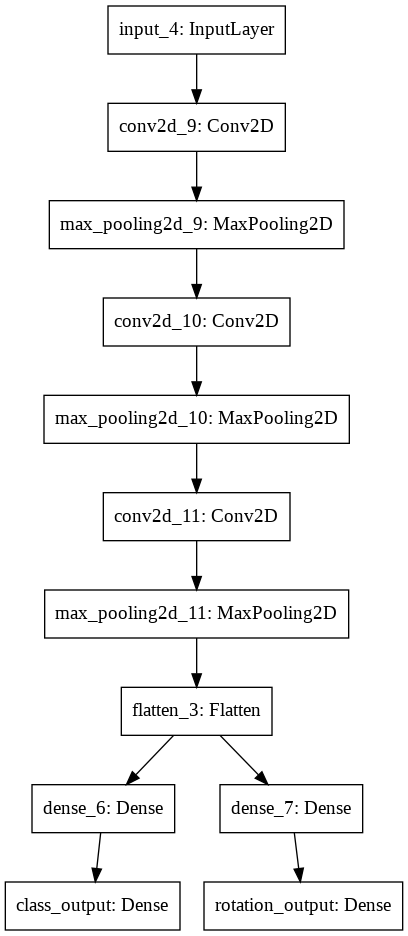

In [31]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [32]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':800,
                'rotation_output':200}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [33]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 5552.6819 - class_output_loss: 0.3025 - rotation_output_loss: 26.5536 - class_output_accuracy: 0.1490 - rotation_output_accuracy: 0.3223 - val_loss: 742708.7500 - val_class_output_loss: 881.5991 - val_rotation_output_loss: 187.1479 - val_class_output_accuracy: 0.0921 - val_rotation_output_accuracy: 0.3556

Epoch 00001: val_class_output_accuracy improved from -inf to 0.09210, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 95975.6256 - class_output_loss: 6.3727 - rotation_output_loss: 454.3874 - class_output_accuracy: 0.1496 - rotation_output_accuracy: 0.3406 - val_loss: 4257364.5000 - val_class_output_loss: 5122.5479 - val_rotation_output_loss: 796.6370 - val_class_output_accuracy: 0.1038 - val_rotation_output_accuracy: 0.3587

Epoch 00002: val_class_output_accuracy improved from 0.09210 to 0.10380, saving model to multi_output_model

## {'class_output':200,'rotation_output':800}

In [34]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [35]:
model_no4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

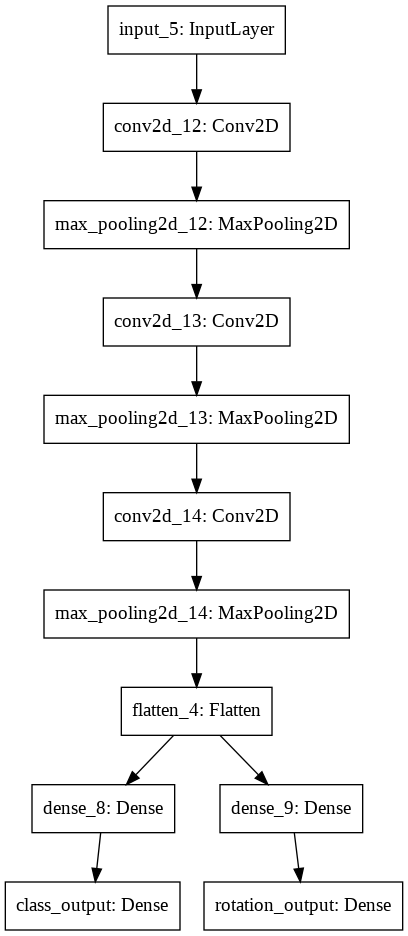

In [36]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [37]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':200,
                'rotation_output':800}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [38]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 16260.8078 - class_output_loss: 0.2065 - rotation_output_loss: 20.2744 - class_output_accuracy: 0.0975 - rotation_output_accuracy: 0.3199 - val_loss: 503622.1875 - val_class_output_loss: 722.9459 - val_rotation_output_loss: 448.7909 - val_class_output_accuracy: 0.1107 - val_rotation_output_accuracy: 0.2875

Epoch 00001: val_class_output_accuracy improved from -inf to 0.11070, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 416973.2199 - class_output_loss: 5.4173 - rotation_output_loss: 519.8619 - class_output_accuracy: 0.0978 - rotation_output_accuracy: 0.3437 - val_loss: 1580952.1250 - val_class_output_loss: 4473.5264 - val_rotation_output_loss: 857.8101 - val_class_output_accuracy: 0.0993 - val_rotation_output_accuracy: 0.3612

Epoch 00002: val_class_output_accuracy did not improve from 0.11070
Epoch 3/100
1563/1563 [==============

## {'class_output':0.0001,'rotation_output':5}

In [39]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [40]:
model_no4.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_15[0][0]           
____________________________________________________________________________________________

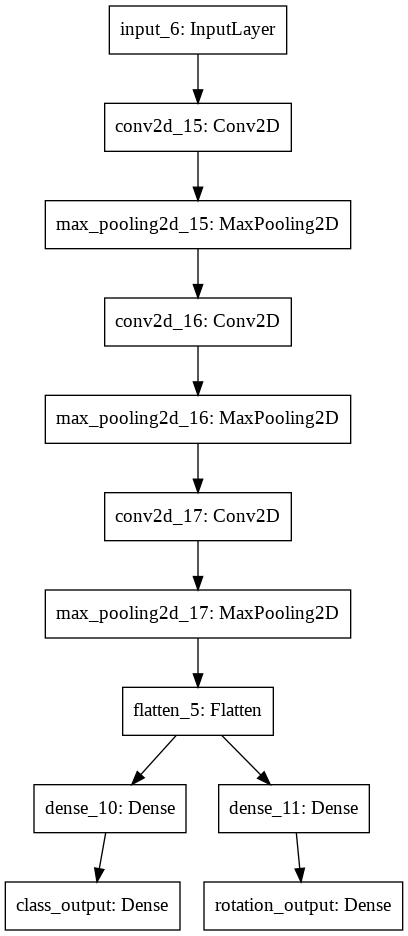

In [41]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [42]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':0.0001,
                'rotation_output':5}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [43]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 16.7224 - class_output_loss: 0.0260 - rotation_output_loss: 3.3445 - class_output_accuracy: 0.1147 - rotation_output_accuracy: 0.3425 - val_loss: 8.3688 - val_class_output_loss: 4.2462 - val_rotation_output_loss: 1.6737 - val_class_output_accuracy: 0.1122 - val_rotation_output_accuracy: 0.4371

Epoch 00001: val_class_output_accuracy improved from -inf to 0.11220, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 7.8323 - class_output_loss: 0.0169 - rotation_output_loss: 1.5665 - class_output_accuracy: 0.1167 - rotation_output_accuracy: 0.4584 - val_loss: 7.0632 - val_class_output_loss: 3.8480 - val_rotation_output_loss: 1.4126 - val_class_output_accuracy: 0.1090 - val_rotation_output_accuracy: 0.4740

Epoch 00002: val_class_output_accuracy did not improve from 0.11220
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step

## {'class_output':5,'rotation_output':0.0001}

In [44]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [45]:
model_no4.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 32)   896         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_18[0][0]           
____________________________________________________________________________________________

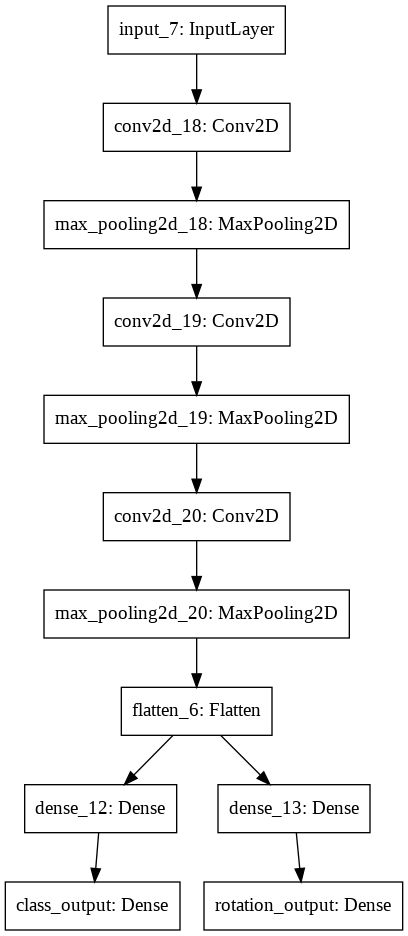

In [46]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [47]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':5,
                'rotation_output':0.0001}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [48]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 1.4097 - class_output_loss: 0.2812 - rotation_output_loss: 35.1937 - class_output_accuracy: 0.0871 - rotation_output_accuracy: 0.3065 - val_loss: 4382.0928 - val_class_output_loss: 876.4128 - val_rotation_output_loss: 306.7969 - val_class_output_accuracy: 0.1053 - val_rotation_output_accuracy: 0.3424

Epoch 00001: val_class_output_accuracy improved from -inf to 0.10530, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 32.4189 - class_output_loss: 6.4707 - rotation_output_loss: 653.7239 - class_output_accuracy: 0.1298 - rotation_output_accuracy: 0.3407 - val_loss: 22884.5840 - val_class_output_loss: 4576.8848 - val_rotation_output_loss: 1752.3518 - val_class_output_accuracy: 0.0950 - val_rotation_output_accuracy: 0.3266

Epoch 00002: val_class_output_accuracy did not improve from 0.10530
Epoch 3/100
1563/1563 [=========================

## {'class_output':1,'rotation_output':0.3}

In [49]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [50]:
model_no4.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 32)   896         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_21[0][0]           
____________________________________________________________________________________________

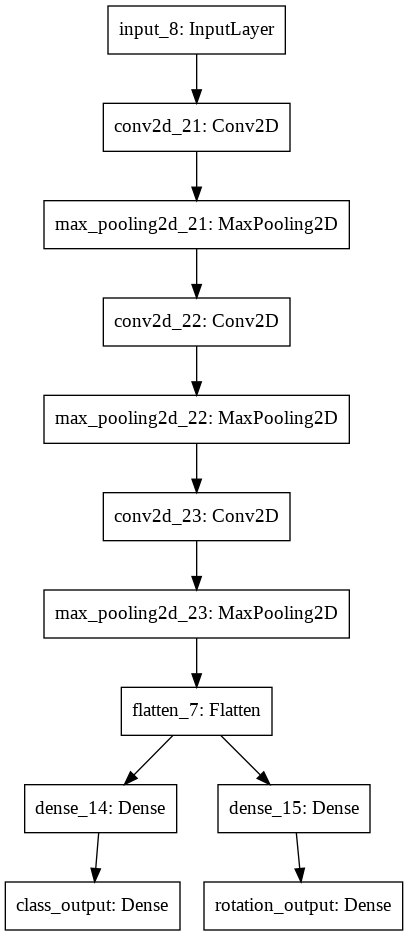

In [51]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [52]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':1,
                'rotation_output':0.3}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [53]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 9.7842 - class_output_loss: 0.2720 - rotation_output_loss: 31.7075 - class_output_accuracy: 0.1311 - rotation_output_accuracy: 0.2920 - val_loss: 723.2559 - val_class_output_loss: 640.7059 - val_rotation_output_loss: 275.1664 - val_class_output_accuracy: 0.1050 - val_rotation_output_accuracy: 0.3591

Epoch 00001: val_class_output_accuracy improved from -inf to 0.10500, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 184.0869 - class_output_loss: 5.7611 - rotation_output_loss: 594.4193 - class_output_accuracy: 0.0933 - rotation_output_accuracy: 0.3379 - val_loss: 4582.0508 - val_class_output_loss: 4281.8535 - val_rotation_output_loss: 1000.6590 - val_class_output_accuracy: 0.0889 - val_rotation_output_accuracy: 0.3932

Epoch 00002: val_class_output_accuracy did not improve from 0.10500
Epoch 3/100
1563/1563 [==========================

## {'class_output':1,'rotation_output':0.1}

In [54]:
# define model

input = Input(shape=(32,32,3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)

hidden1 = Dense(128, activation='elu')(flat)
output1 = Dense(10, activation='softmax', name='class_output')(hidden1)

hidden2 = Dense(128, activation='elu')(flat)
output2 = Dense(4, activation='softmax', name='rotation_output')(hidden2)


model_no4 = Model(inputs=input, outputs=[output1, output2])

In [55]:
model_no4.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 16, 16, 64)   18496       max_pooling2d_24[0][0]           
____________________________________________________________________________________________

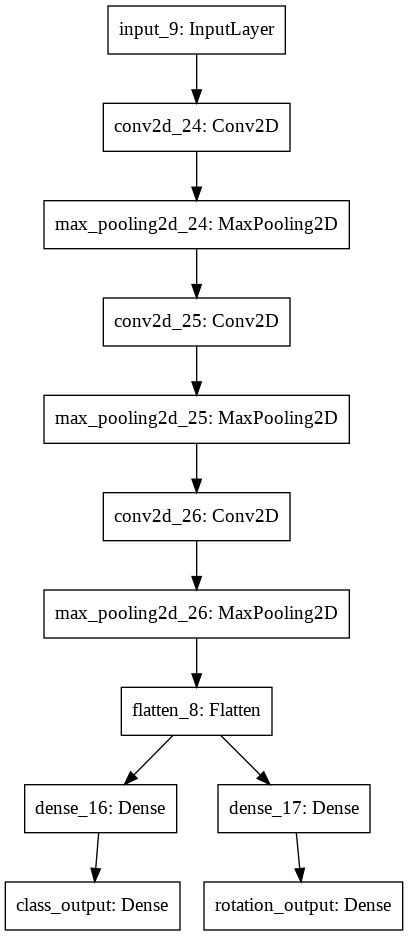

In [56]:
keras.utils.plot_model(model_no4, "multi_output_functional_model.png")

In [57]:
# compile
losses = {'class_output':'categorical_crossentropy',
          'rotation_output':'categorical_crossentropy'}

loss_weights = {'class_output':1,
                'rotation_output':0.1}

opt = keras.optimizers.Adam(learning_rate=0.00001)

metrics = {'class_output':'accuracy',
           'rotation_output':'accuracy'}

model_no4.compile(loss=losses, loss_weights=loss_weights, optimizer=opt, metrics=metrics)

In [58]:
# training
es_callback = keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", min_delta=0.001, patience=20)


path_checkpoint = "multi_output_model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_class_output_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no4 = model_no4.fit(x = X_train,
                            y = Y_train,
                            epochs=100,
                            validation_data=(X_test, Y_test),
                            callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
1563/1563 [==============================] - 9s 5ms/step - loss: 2.6718 - class_output_loss: 0.2259 - rotation_output_loss: 24.4595 - class_output_accuracy: 0.0075 - rotation_output_accuracy: 0.3070 - val_loss: 681.2378 - val_class_output_loss: 650.5801 - val_rotation_output_loss: 306.5766 - val_class_output_accuracy: 0.1041 - val_rotation_output_accuracy: 0.3509

Epoch 00001: val_class_output_accuracy improved from -inf to 0.10410, saving model to multi_output_model_checkpoint.h5
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 51.0813 - class_output_loss: 4.6206 - rotation_output_loss: 464.6074 - class_output_accuracy: 0.0231 - rotation_output_accuracy: 0.3546 - val_loss: 4053.0537 - val_class_output_loss: 3964.9004 - val_rotation_output_loss: 881.5216 - val_class_output_accuracy: 0.0954 - val_rotation_output_accuracy: 0.3433

Epoch 00002: val_class_output_accuracy did not improve from 0.10410
Epoch 3/100
1563/1563 [============================

# **Part 4: ت**

In [10]:
def extract_channal(im, channel):
  y = [0,0,0]
  ch = im[:,:,channel]
  ch = np.expand_dims(ch, axis=2)
  y[channel]=1

  return ch,y

In [11]:
def channel_labeling(x_train, x_test):
    xy_r_train = list(zip(*[extract_channal(im, 0) for im in x_train]))
    xy_r_test = list(zip(*[extract_channal(im, 0) for im in x_test]))


    x_r_train=np.array(xy_r_train[0][:])
    y_r_train=np.array(xy_r_train[1][:])
    x_r_test=np.array(xy_r_test[0][:])
    y_r_test=np.array(xy_r_test[1][:])



    xy_g_train = list(zip(*[extract_channal(im, 1) for im in x_train]))
    xy_g_test = list(zip(*[extract_channal(im, 1) for im in x_test]))

    x_g_train=np.array(xy_g_train[0][:])
    y_g_train=np.array(xy_g_train[1][:])
    x_g_test=np.array(xy_g_test[0][:])
    y_g_test=np.array(xy_g_test[1][:])



    xy_b_train = list(zip(*[extract_channal(im, 2) for im in x_train]))
    xy_b_test = list(zip(*[extract_channal(im, 2) for im in x_test]))

    x_b_train=np.array(xy_b_train[0][:])
    y_b_train=np.array(xy_b_train[1][:])
    x_b_test=np.array(xy_b_test[0][:])
    y_b_test=np.array(xy_b_test[1][:])


    x_channel_train = np.concatenate([x_r_train, x_g_train, x_b_train] , axis=0)
    y_channel_train = np.concatenate([y_r_train, y_g_train, y_b_train] , axis=0)
    x_channel_test = np.concatenate([x_r_test, x_g_test, x_b_test] , axis=0)
    y_channel_test = np.concatenate([y_r_test, y_g_test, y_b_test] , axis=0)

    return x_channel_train,y_channel_train,x_channel_test,y_channel_test

In [12]:
x_channel_train,y_channel_train,x_channel_test,y_channel_test = channel_labeling(x_unlabeld,x_test)

In [13]:
print(x_channel_train.shape)
print(y_channel_train.shape)
print(x_channel_test.shape)
print(y_channel_test.shape)

(149400, 32, 32, 1)
(149400, 3)
(30000, 32, 32, 1)
(30000, 3)


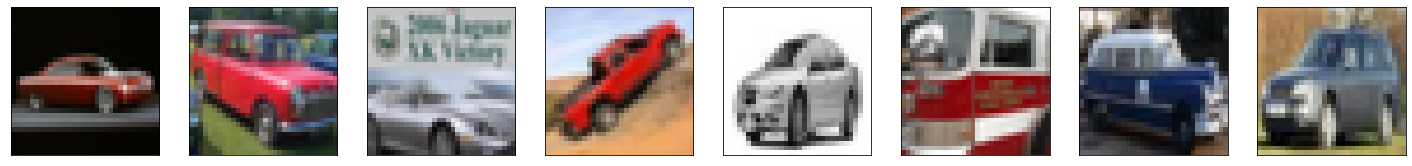

In [14]:
plt.figure(figsize=(25, 4))
for i in range(8):
  plt.subplot(1, 8, i + 1)
  plt.imshow(x_unlabeld[i])
  plt.xticks([])
  plt.yticks([])


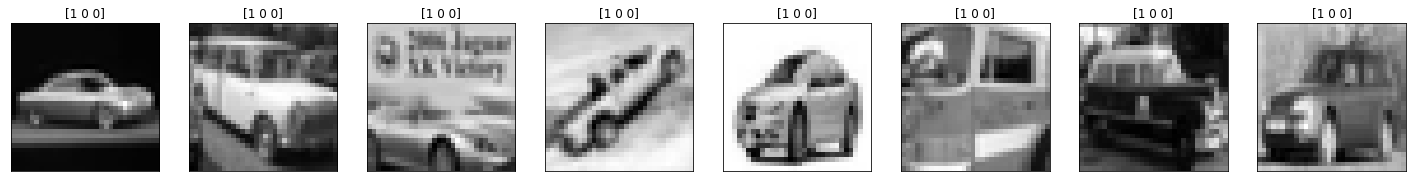

In [15]:
plt.figure(figsize=(25, 4))
for i in range(8):
  plt.subplot(1, 8, i + 1)
  plt.imshow(np.squeeze(x_channel_train[i], axis=(2,)), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(str(y_channel_train[i]))

In [16]:
# data augmentation
channel_train_datagen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

channel_test_datagen = ImageDataGenerator(rescale=1./255)

channel_train_generator = channel_train_datagen.flow(x_channel_train, y_channel_train, batch_size=256)
channel_validation_generator = channel_test_datagen.flow(x_channel_test, y_channel_test, batch_size=256)

In [17]:
# define model

input = Input(shape=(32,32,1))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same')(input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv3 = Conv2D(64, kernel_size=(3, 3), activation='elu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv5 = Conv2D(128, kernel_size=(3, 3), activation='elu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool3)
hidden1 = Dense(128, activation='elu')(flat)
output = Dense(3, activation='softmax')(hidden1)

model_no5 = Model(input, output)

In [18]:
# compile

model_no5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_no5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0     

In [19]:
# training

channel_path_checkpoint = "channel_model_checkpoint.h5"
channel_es_callback = keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=0.001, patience=2)

channel_modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_acc",
    filepath=channel_path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history_no5 = model_no5.fit(channel_train_generator,
            epochs=100,
            validation_data=channel_validation_generator,
            callbacks=[channel_es_callback, channel_modelckpt_callback])

Epoch 1/100
584/584 [==============================] - 96s 113ms/step - loss: 1.0908 - acc: 0.3927 - val_loss: 1.0615 - val_acc: 0.4288

Epoch 00001: val_acc improved from -inf to 0.42877, saving model to channel_model_checkpoint.h5
Epoch 2/100
584/584 [==============================] - 65s 111ms/step - loss: 1.0640 - acc: 0.4236 - val_loss: 1.0511 - val_acc: 0.4370

Epoch 00002: val_acc improved from 0.42877 to 0.43703, saving model to channel_model_checkpoint.h5
Epoch 3/100
584/584 [==============================] - 65s 112ms/step - loss: 1.0580 - acc: 0.4291 - val_loss: 1.0467 - val_acc: 0.4456

Epoch 00003: val_acc improved from 0.43703 to 0.44563, saving model to channel_model_checkpoint.h5
Epoch 4/100
584/584 [==============================] - 65s 112ms/step - loss: 1.0551 - acc: 0.4324 - val_loss: 1.0446 - val_acc: 0.4499

Epoch 00004: val_acc improved from 0.44563 to 0.44993, saving model to channel_model_checkpoint.h5
Epoch 5/100
584/584 [==============================] - 65s 

In [ ]:
model_no5.save(rot_path_checkpoint)

In [ ]:
# define model

channel_model= keras.models.load_model(channel_path_checkpoint)
channel_model.trainable = True

x = channel_model.layers[-2].output
x = Dense(10, activation='softmax')(x)
model_no6 = Model(channel_model.inputs,x)

In [ ]:
# compile
model_no6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_no6.summary()

In [ ]:
# training


main_path_checkpoint = "main_model_checkpoint.h5"
main_es_callback = keras.callbacks.EarlyStopping(monitor="val_acc", min_delta=0, patience=20)

main_modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_acc",
    filepath=main_path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


history_no6 = model_no6.fit(train_generator,
            epochs=500,
            validation_data=validation_generator,
            callbacks=[main_es_callback, main_modelckpt_callback])